In [9]:
!pip install gymnasium torch scipy matplotlib

In [10]:
import os
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque, OrderedDict
import math
from scipy.integrate import solve_ivp
from typing import Tuple, Union, Any, SupportsFloat, TypeVar, List, Sequence, Dict
from numpy import ndarray

# Set device
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ObsType = TypeVar("ObsType")

In [11]:
import os
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque, OrderedDict
import math
from scipy.integrate import solve_ivp
from typing import Tuple, Union, Any, SupportsFloat, TypeVar, List, Sequence, Dict
from numpy import ndarray

# Set device
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ObsType = TypeVar("ObsType")

# Step 1: Initialize the Experience Replay memory
class ReplayBuffer(object):
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = int(max_size)
        self.ptr = 0

    def add(self, transition):
        if len(self.storage) == self.max_size:
            self.storage[self.ptr] = transition
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(transition)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
        for i in ind:
            state, next_state, action, reward, done = self.storage[i]
            batch_states.append(np.asarray(state))
            batch_next_states.append(np.asarray(next_state))
            batch_actions.append(np.asarray(action))
            batch_rewards.append(np.asarray(reward))
            batch_dones.append(np.asarray(done))

        batch_actions = np.array(batch_actions)
        if batch_actions.ndim == 1:
            batch_actions = np.expand_dims(batch_actions, axis=1)

        return np.array(batch_states), np.array(batch_next_states), batch_actions, \
               np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

# Step 2: Build one neural network for the Actor model and one for the Actor target
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer_1 = nn.Linear(state_dim, 100)
        self.layer_2 = nn.Linear(100, 30)
        self.layer_3 = nn.Linear(30, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        # Using sigmoid to keep action between 0 and max_action
        x = self.max_action * torch.sigmoid(self.layer_3(x))
        return x

# Step 3: Build two neural networks for the two Critic models and two for the two Critic targets
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Defining the first Critic neural network
        self.layer_1 = nn.Linear(state_dim + action_dim, 100)
        self.layer_2 = nn.Linear(100, 30)
        self.layer_3 = nn.Linear(30, 1)
        # Defining the second Critic neural network
        self.layer_4 = nn.Linear(state_dim + action_dim, 100)
        self.layer_5 = nn.Linear(100, 30)
        self.layer_6 = nn.Linear(30, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)
        # Forward-Propagation on the first Critic Neural Network
        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)
        # Forward-Propagation on the second Critic Neural Network
        x2 = F.relu(self.layer_4(xu))
        x2 = F.relu(self.layer_5(x2))
        x2 = self.layer_6(x2)
        return x1, x2

    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = F.relu(self.layer_1(xu))
        x1 = F.relu(self.layer_2(x1))
        x1 = self.layer_3(x1)
        return x1

# Steps 4 to 15: Training Process
class TD3(object):
    def __init__(self, state_dim, action_dim, max_action, device):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
        self.max_action = max_action
        self.action_dim = action_dim
        self.device = device
        self.expl_noise = 0.1 # Exploration noise

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            # Random action
            action_scalar = np.random.random() * self.max_action
            noise = np.random.normal(0, self.expl_noise, size=self.action_dim)
            action = (action_scalar + noise).clip(0, self.max_action)
            # Ensure it's a scalar if action_dim is 1
            action = float(action[0]) if self.action_dim == 1 else action
        else:
            # Policy action
            state_tensor = torch.Tensor(state.reshape(1, -1)).to(self.device)
            action_tensor = self.actor(state_tensor).cpu().data.numpy().flatten()
            noise = np.random.normal(0, self.expl_noise, size=self.action_dim)
            action = (action_tensor + noise).clip(0, self.max_action)
            # Ensure it's a scalar if action_dim is 1
            action = float(action[0]) if self.action_dim == 1 else action
        return action

    def train(self, replay_buffer, iterations, batch_size, discount=0.99, tau=0.005, policy_noise=0.2,
              noise_clip=0.5, policy_freq=2):
        for it in range(iterations):
            # Step 4: Sample a batch
            batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
            state = torch.Tensor(batch_states).to(self.device).type(dtype)
            next_state = torch.Tensor(batch_next_states).to(self.device).type(dtype)
            action = (torch.from_numpy(np.asarray(batch_actions))).to(self.device).type(dtype)
            reward = torch.Tensor(batch_rewards).to(self.device).type(dtype)
            done = torch.Tensor(batch_dones).to(self.device).type(dtype)

            # Step 5: Get target action
            next_action = self.actor_target(next_state)

            # Step 6: Add noise to target action
            noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(self.device).type(dtype)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (next_action + noise).clamp(0, self.max_action)

            # Step 7 & 8: Get target Q-values
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)

            # Step 9: Compute final target
            target_Q = reward + ((1 - done) * discount * target_Q).detach()

            # Step 10: Get current Q-values
            current_Q1, current_Q2 = self.critic(state, action)

            # Step 11: Compute Critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            # Step 12: Optimize Critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Step 13: Delayed policy update
            if it % policy_freq == 0:
                actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Step 14 & 15: Update target networks (Polyak averaging)
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), f'{directory}/{filename}_actor.pth')
        torch.save(self.critic.state_dict(), f'{directory}/{filename}_critic.pth')

    def load(self, filename, directory):
        self.actor.load_state_dict(torch.load(f'{directory}/{filename}_actor.pth', map_location=self.device))
        self.critic.load_state_dict(torch.load(f'{directory}/{filename}_critic.pth', map_location=self.device))
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

In [12]:
from abc import abstractmethod

class BaseSimulator:
    def __init__(self):
        pass

    @abstractmethod
    def activate(self) -> OrderedDict[str, ndarray]:
        raise NotImplementedError

    @abstractmethod
    def update(self, action: Union[dict, float], state: dict, integral_num: int = 10) -> OrderedDict[str, ndarray]:
        raise NotImplementedError

class BaseReward:
    def __init__(self):
        pass

    @abstractmethod
    def count_reward(self, *args, **kwargs) -> float:
        raise NotImplementedError

def uniform_random(mean, width, absolute=False):
    def single_random(mean, width):
        if absolute:
            return float(np.random.uniform(mean - width, mean + width))
        else:
            return float(np.random.uniform(mean - mean * width, mean + mean * width))

    if isinstance(mean, (list, pd.core.series.Series, np.ndarray)) if 'pd' in globals() else isinstance(mean, (list, np.ndarray)):
        out = []
        for m in mean:
            out.append(single_random(m, width))
        return out
    elif isinstance(mean, (int, float, np.float32, np.float64, np.int64, np.int32)):
        return single_random(mean, width)
    else:
        raise NotImplementedError(f"mean type {type(mean)} not supported")

In [13]:
class AhnReward(BaseReward):
    def __init__(self):
        super().__init__()

    def count_reward(self, state, init_state, action, terminated) -> float:
        N, T, I, B = state["N"], state["T"], state["I"], state["B"]
        N0, T0, I0, B0 = init_state["N"], init_state["T"], init_state["I"], init_state["B"]
        reward = N/N0 - T/T0 - action
        if terminated:  # patient die
            return -100
        return float(reward)


class AhnODE(BaseSimulator):
    def __init__(self, state_noise, pkpd_noise):
        super().__init__()
        self.state_noise = state_noise
        self.pkpd_noise = pkpd_noise
        self.cur_time = 0  # unit is day
        self.time_interv = 0.25  # 6h

    def activate(self) -> OrderedDict[str, ndarray]:
        width = self.pkpd_noise * 0.5
        self.r2, self.b2, self.c4, self.a3 = uniform_random(1., width), uniform_random(1., width), uniform_random(
            1., width), uniform_random(0.1, width)
        self.r1, self.b1, self.c2, self.c3, self.a2 = uniform_random(1.5, width), uniform_random(1., width), \
            uniform_random(0.5, width), uniform_random(1., width), uniform_random(0.3, width)
        self.s, self.rho, self.alpha, self.c1, self.d1, self.a1 = uniform_random(0.33, width), uniform_random(0.01,
                                                                                                              width), \
            uniform_random(0.3, width), uniform_random(1., width), uniform_random(0.2, width), uniform_random(0.2,
                                                                                                              width)
        self.d2 = uniform_random(1., width)

        init_state = OrderedDict({"N": np.array([uniform_random(0.9, self.state_noise*0.5)], dtype=np.float32),
                                  "T": np.array([uniform_random(0.2, self.state_noise*0.5)], dtype=np.float32),
                                  "I": np.array([uniform_random(0.005, self.state_noise*0.5)], dtype=np.float32),
                                  "B": np.array([0.0], dtype=np.float32)})
        # Reset cur_time on activation
        self.cur_time = 0
        return init_state

    def update(self, action: Union[dict, float, np.ndarray], state: OrderedDict) -> OrderedDict[str, Union[float, Any]]:

        def odes_fn(t, variables, u):
            N, T, I, B = variables
            dNdt = self.r2 * N * (1 - self.b2 * N) - self.c4 * T * N - self.a3 * (1 - np.exp(-B)) * N
            dTdt = self.r1 * T * (1 - self.b1 * T) - self.c2 * I * T - self.c3 * T * N - self.a2 * (1 - np.exp(-B)) * T
            dIdt = self.s + self.rho * I * T / (self.alpha + T) - self.c1 * I * T - self.d1 * I - self.a1 * (
                        1 - np.exp(-B)) * I
            dBdt = -self.d2 * B + u

            if self.state_noise > 0:
                noise = np.random.normal(0, self.state_noise, 4)
                dNdt += dNdt * noise[0]
                dTdt += dTdt * noise[1]
                dIdt += dIdt * noise[2]
                dBdt += dBdt * noise[3]
            return [dNdt, dTdt, dIdt, dBdt]

        variables = np.array((state["N"], state["T"], state["I"], state["B"])).flatten()

        # Action is expected to be array-like for indexing, e.g., [0.5]
        scalar_action = action[0]

        solution = solve_ivp(odes_fn, (self.cur_time, self.cur_time + self.time_interv),
                             variables, args=(scalar_action,))

        N, T, I, B = solution.y[0, -1], solution.y[1, -1], solution.y[2, -1], solution.y[3, -1]
        N, T, I, B = max(0, N), max(0, T), max(0, I), max(0, B)
        self.cur_time += self.time_interv
        return OrderedDict({"N": np.array([N], dtype=np.float32),
                            "T": np.array([T], dtype=np.float32),
                            "I": np.array([I], dtype=np.float32),
                            "B": np.array([B], dtype=np.float32)})


class AhnChemoEnv(gym.Env):
    def __init__(self, max_t: int = 600, delayed_steps=0,
                 obs_noise=0.2, state_noise=0.5, pkpd_noise=0.1,
                 missing_rate=0.0, **kwargs):
        super().__init__()
        self.Simulator = AhnODE(state_noise=state_noise, pkpd_noise=pkpd_noise)
        self.Reward = AhnReward()
        self.obs_noise = obs_noise
        self.state_noise = state_noise
        self.pkpd_noise = pkpd_noise
        self.max_t = max_t
        self.missing_rate = missing_rate

        self.init_state = None
        self.cur_state = None
        self.last_obs = None
        self.terminated = False
        self.truncated = False
        self.t = None
        # Observation: T, I, B
        self.observation_space = spaces.Box(low=np.array([0.0, 0.0, 0.0]),
                                            high=np.array([2., 2.0, 1.0]), shape=(3,), dtype=np.float32)
        # Action: Drug dosage (continuous)
        self.action_space = spaces.Box(
            low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        self.env_info = {'action_type': 'continuous', 'reward_range': (0, 4),
                         "state_key": ["Normal Cell Population",
                                       "Tumor Cell Population",
                                       "Immune Cell Population",
                                       "Drug Concentration"],
                         "obs_key": ["Tumor Cell Population",
                                     "Immune Cell Population",
                                     "Drug Concentration"],
                         "act_key": ["Drug Dosage"]}
        self.state_map = {"N": "Normal Cell Population",
                          "T": "Tumor Cell Population",
                          "I": "Immune Cell Population",
                          "B": "Drug Concentration"}
        self.delayed_steps = delayed_steps
        if self.delayed_steps > 0:
            self.acc_rew = 0

    def _state2obs(self, state: OrderedDict, enable_missing: bool) -> np.ndarray:
        obs = np.array([state['T'], state['I'], state["B"]]).flatten()
        obs_noise = self.obs_noise * obs * np.random.uniform(-0.5, 0.5, size=obs.shape)
        obs = obs + obs_noise
        obs = np.clip(obs, self.observation_space.low,
                      self.observation_space.high).astype(np.float32)

        if enable_missing and np.random.uniform(0, 1) < self.missing_rate:
            obs = self.last_obs
        else:
            self.last_obs = obs
        return obs

    def reset(self, seed: int = None, **kwargs) -> Tuple[ObsType, dict[str, Any]]:
        super().reset(seed=seed)
        if seed is not None:
            np.random.seed(seed)

        self.t = 0
        self.terminated = False
        self.truncated = False

        init_state = self.Simulator.activate()
        self.init_state = init_state
        self.cur_state = init_state
        init_observation = self._state2obs(init_state, enable_missing=False)

        if self.delayed_steps > 0:
            self.acc_rew = 0

        state_info = {self.state_map[key]: value[0] for key, value in init_state.items()}
        info = {"state": state_info, "action": np.zeros(shape=(1,)), "instantaneous_reward": 0}

        try:
            self.spec.reward_threshold = self.env_info['reward_range'][1]
        except AttributeError:
            pass # Spec might not be set

        return init_observation, info

    def step(self, action: float) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        if self.terminated or self.truncated:
            raise RuntimeError("This treat is end, please call reset")

        # Ensure action is a scalar float
        action_scalar = float(action)

        if action_scalar < self.action_space.low[0] or action_scalar > self.action_space.high[0]:
            # Clip action instead of raising error to be more robust
            action_scalar = np.clip(action_scalar, self.action_space.low[0], self.action_space.high[0])

        # *** FIX ***
        # AhnODE.update expects an array-like action to index [0]
        # We pass the scalar action for reward calculation
        action_array = np.array([action_scalar])
        state_next = self.Simulator.update(action=action_array, state=self.cur_state)
        # *** END FIX ***

        observation_next = self._state2obs(state_next, enable_missing=True)

        if state_next["N"] < self.init_state["N"] * 0.7:  # die
            self.terminated = True
        if self.t + 1 >= self.max_t:
            self.truncated = True

        # Use the original scalar action for reward calculation
        r = self.Reward.count_reward(
            state=self.cur_state, init_state=self.init_state, action=action_scalar, terminated=self.terminated)

        if self.delayed_steps > 0:
            self.acc_rew += r
            if self.t % self.delayed_steps == 0 or self.truncated or self.terminated:
                reward = self.acc_rew
                self.acc_rew = 0
            else:
                reward = 0
        else:
            reward = r

        self.t += 1
        self.cur_state = state_next
        state_info = {self.state_map[key]: value[0] for key, value in state_next.items()}
        info = {"state": state_info, "action": action_scalar, "instantaneous_reward": r}

        return observation_next, reward, self.terminated, self.truncated, info


# Environment creator function for the simplest setting (no noise)
def create_AhnChemoEnv_continuous_setting1(max_t: int = 600, **kwargs):
    env = AhnChemoEnv(max_t, delayed_steps=0, obs_noise=0.0, state_noise=0.0,
                      pkpd_noise=0.0, missing_rate=0.0, **kwargs)
    return env

State Dimension: 3
Action Dimension: 1
Max Action: 1.0
--- Starting Training ---

--- Episode 0, Epsilon 1.0000 ---
  Step 100, Obs(T,I,B): [0.21661288 0.656098   0.60142285], Action: 0.6473, Reward: -0.9205
  Step 200, Obs(T,I,B): [0.12932086 0.8078643  0.41934553], Action: 0.5183, Reward: -0.2500
  Step 300, Obs(T,I,B): [0.02072798 1.0633181  0.6115841 ], Action: 0.7691, Reward: 0.1610
  Step 400, Obs(T,I,B): [4.0830427e-04 1.1584083e+00 7.0022732e-01], Action: 0.6223, Reward: 0.4344
  Step 500, Obs(T,I,B): [5.4628008e-06 1.1786065e+00 4.9503464e-01], Action: 0.8845, Reward: 0.1828


/tmp/ipython-input-2576433759.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(reward)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  Step 200, Obs(T,I,B): [0.2484407  0.6946365  0.12912546], Action: 0.0006, Reward: -0.4247
  Step 300, Obs(T,I,B): [0.24895261 0.7181334  0.05629816], Action: 0.0063, Reward: -0.4222
  Step 400, Obs(T,I,B): [0.25835758 0.69908094 0.13742222], Action: 0.1619, Reward: -0.6431
  Step 500, Obs(T,I,B): [0.25280115 0.69222    0.12551908], Action: 0.0012, Reward: -0.4513
  Step 600, Obs(T,I,B): [0.25605437 0.70282793 0.1587363 ], Action: 0.3334, Reward: -0.7999
  Step 700, Obs(T,I,B): [0.2504765  0.68537796 0.23623377], Action: 0.4377, Reward: -0.8794
  Step 800, Obs(T,I,B): [0.2523095  0.6991241  0.10558772], Action: 0.0000, Reward: -0.4428
  Step 900, Obs(T,I,B): [0.24943896 0.70153874 0.10306919], Action: 0.0800, Reward: -0.5035
  Step 1000, Obs(T,I,B): [0.2527447  0.6952532  0.13908957], Action: 0.1209, Reward: -0.5701
Episode 636 finished after 1000 steps. Total Reward: -584.1845

--- Episode 637, Epsilon 0.05

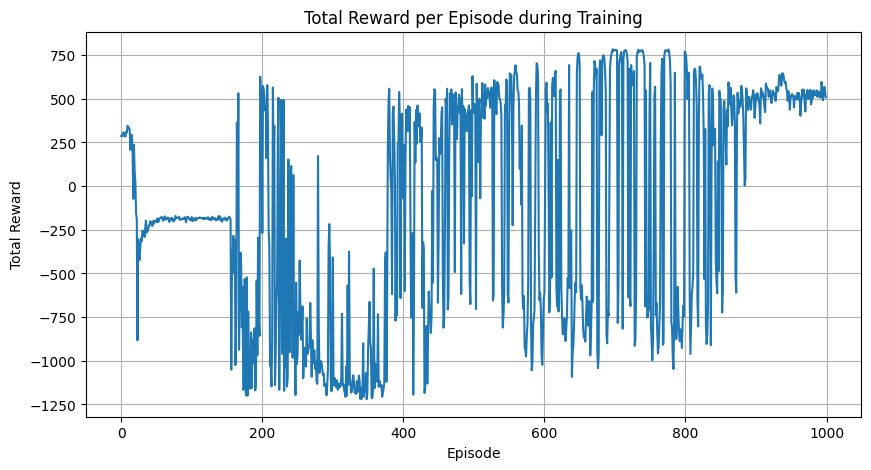


--- Loading models for inference ---
--- Starting inference ---
Inference finished after 1000 steps.
--- Plotting Inference Results ---


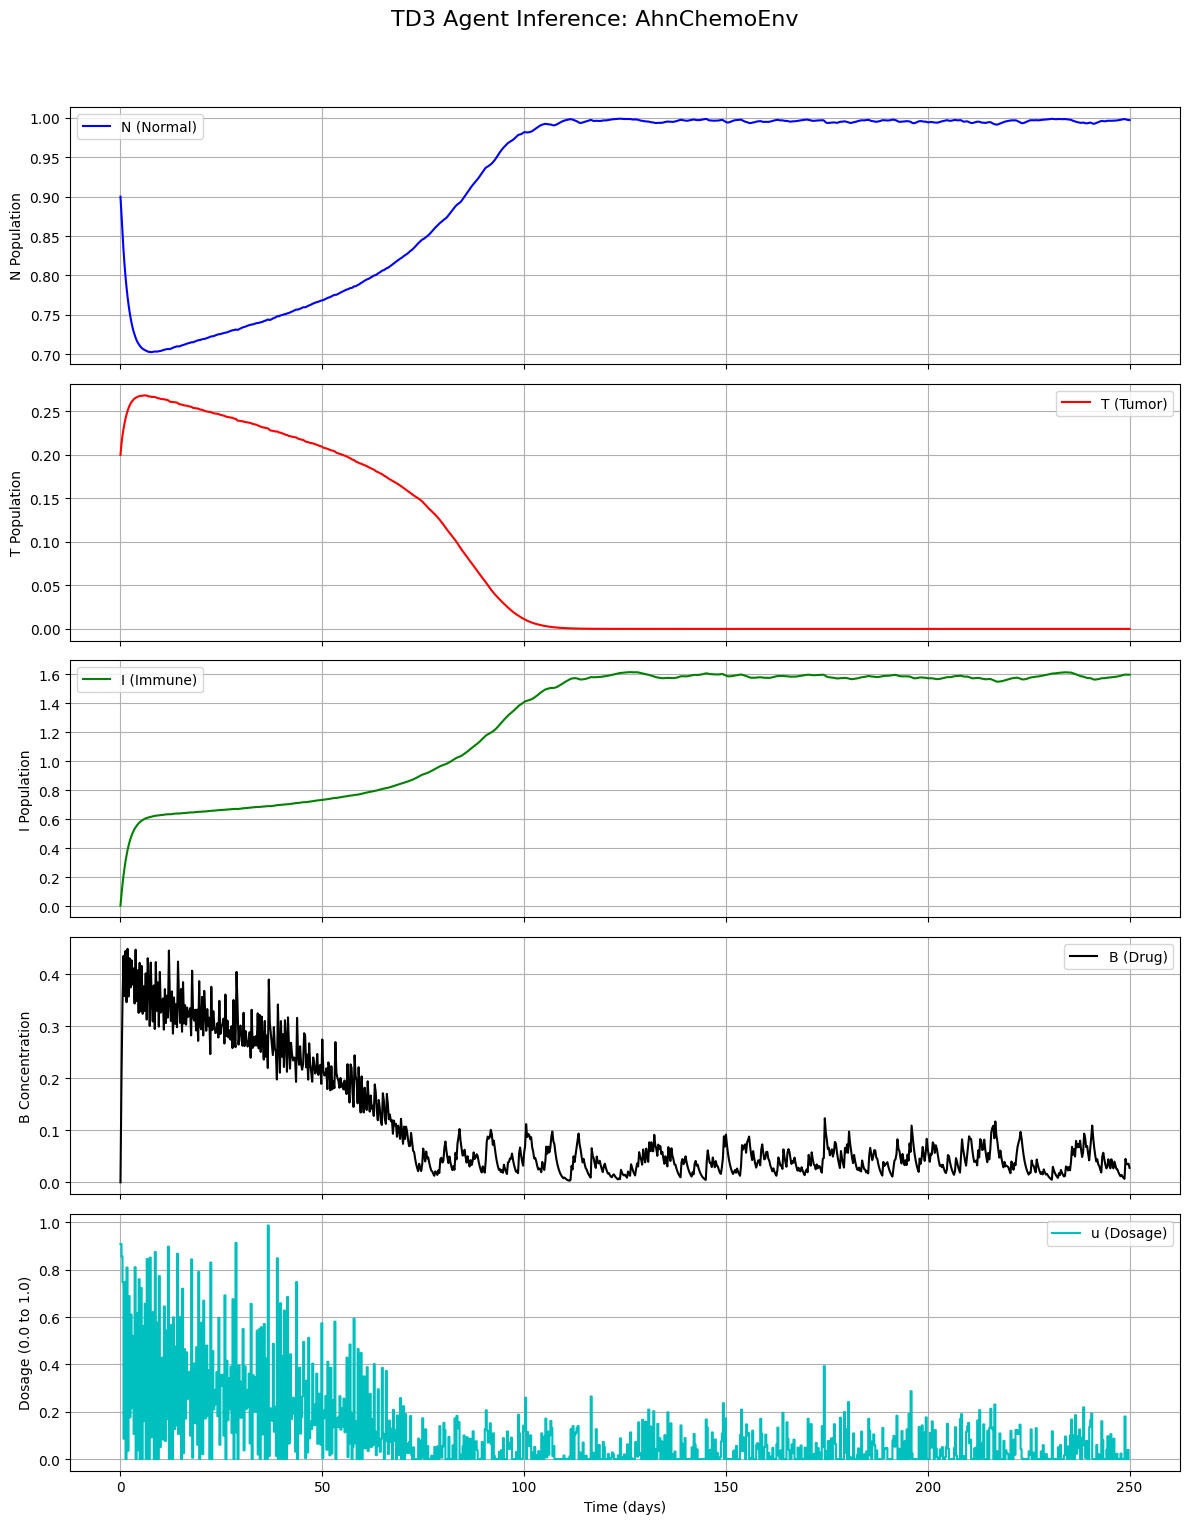

In [14]:
# --- Training Hyperparameters ---
log = False
attempt = 4 # New attempt number
seed = 0
max_mem_size = 1e6
eval_freq = 5 # Evaluate every 5 episodes
save_models = True
batch_size = 100 # Smaller batch size for more frequent updates
discount = 0.99  # Standard gamma
tau = 0.005
policy_noise = 0.2
noise_clip = 0.5
policy_freq = 2

episodes = 1000 # Run for more episodes
max_steps = 1000 # 600 steps = 150 days (600 * 0.25)
max_train_steps = 40 # Training iterations per episode
warm_up_episodes = 5

# Epsilon parameters for exploration
epsilon_start = 1.0
epsilon_decay = 0.95
epsilon_min = 0.05

# --- Setup File Paths ---
folder_path1 = f'./results_AhnChemo_TD3'
folder_path2 = f'./pytorch_models_AhnChemo_TD3'
env_name = 'AhnChemo-v1'
file_name = f"TD3_{env_name}_{seed}"

if not os.path.exists(folder_path1):
    os.makedirs(folder_path1)
if save_models and not os.path.exists(folder_path2):
    os.makedirs(folder_path2)

# --- Set Seeds ---
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# --- Initialize Environment ---
env = create_AhnChemoEnv_continuous_setting1(max_t=max_steps)

# --- Initialize Policy and Replay Buffer ---
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

print(f"State Dimension: {state_dim}")
print(f"Action Dimension: {action_dim}")
print(f"Max Action: {max_action}")

policy = TD3(state_dim=state_dim, action_dim=action_dim, max_action=max_action, device=device)
replay_buffer = ReplayBuffer(max_size=max_mem_size)

# --- Evaluation Function ---
def evaluate_policy(policy, eval_episodes=10):
    print('... Evaluating Policy ...')
    eval_env = create_AhnChemoEnv_continuous_setting1(max_t=max_steps)
    avg_reward = 0.
    for _ in range(eval_episodes):
        obs, info = eval_env.reset()
        done = False
        steps = 0
        while not done:
            action = policy.select_action(obs, epsilon=0) # Epsilon 0 for deterministic eval
            next_obs, reward, terminated, truncated, info = eval_env.step(action)
            obs = next_obs
            done = terminated or truncated
            avg_reward += reward
    avg_reward /= eval_episodes
    print("---------------------------------------")
    print(f"Average Reward over {eval_episodes} Evaluation Episodes: {avg_reward}")
    return avg_reward

# --- Training Loop (Simulate) ---
def simulate():
    epsilon = epsilon_start
    total_rewards = []

    print('--- Starting Training ---')
    for episode in range(episodes):
        print(f'\n--- Episode {episode}, Epsilon {epsilon:.4f} ---')
        steps = 0
        terminated = False
        truncated = False

        obs, info = env.reset(seed=seed+episode) # Vary seed per episode
        episode_reward = 0

        while not (terminated or truncated):
            action = policy.select_action(obs, epsilon)

            new_obs, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated
            replay_buffer.add((obs, new_obs, action, reward, float(done)))

            obs = new_obs
            episode_reward += reward
            steps += 1

            if steps % 100 == 0:
                 print(f'  Step {steps}, Obs(T,I,B): {obs}, Action: {action:.4f}, Reward: {reward:.4f}')

        print(f'Episode {episode} finished after {steps} steps. Total Reward: {episode_reward:.4f}')
        total_rewards.append(episode_reward)

        # Epsilon decay
        if episode >= warm_up_episodes:
            epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Train policy
        if len(replay_buffer.storage) > batch_size:
            policy.train(replay_buffer, max_train_steps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)

        # Evaluate and save models
        if episode % eval_freq == 0 and len(replay_buffer.storage) > batch_size:
            avg_eval_reward = evaluate_policy(policy)
            if save_models:
                print('... Saving models ...')
                policy.save(file_name, directory=folder_path2)

    # Plot training rewards
    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards)
    plt.title('Total Reward per Episode during Training')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.savefig(f'{folder_path1}/training_rewards.png')
    plt.show()

# --- Inference Function ---
def inference():
    print('\n--- Loading models for inference ---')
    policy.load(file_name, folder_path2)

    print('--- Starting inference ---')
    inf_env = create_AhnChemoEnv_continuous_setting1(max_t=max_steps)
    obs, info = inf_env.reset(seed=42) # Use a fixed seed for inference

    steps = 0
    N_pop, T_pop, I_pop, B_conc = [], [], [], []
    actions_taken = []

    terminated = False
    truncated = False

    # Store initial state
    N_pop.append(info['state']['Normal Cell Population'])
    T_pop.append(info['state']['Tumor Cell Population'])
    I_pop.append(info['state']['Immune Cell Population'])
    B_conc.append(info['state']['Drug Concentration'])

    while not (terminated or truncated):
        action = policy.select_action(obs, epsilon=0) # Epsilon 0 for deterministic
        actions_taken.append(action)

        obs, reward, terminated, truncated, info = inf_env.step(action)

        # Store full state from info dict
        N_pop.append(info['state']['Normal Cell Population'])
        T_pop.append(info['state']['Tumor Cell Population'])
        I_pop.append(info['state']['Immune Cell Population'])
        B_conc.append(info['state']['Drug Concentration'])

        steps += 1

    print(f'Inference finished after {steps} steps.')

    # --- Plotting Inference Results ---
    print('--- Plotting Inference Results ---')
    fig, axs = plt.subplots(5, 1, figsize=(12, 16), sharex=True)

    # Time axis (each step is 0.25 days)
    time_axis = np.arange(len(N_pop)) * 0.25

    axs[0].plot(time_axis, N_pop, 'b', label='N (Normal)')
    axs[0].set_ylabel('N Population')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(time_axis, T_pop, 'r', label='T (Tumor)')
    axs[1].set_ylabel('T Population')
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(time_axis, I_pop, 'g', label='I (Immune)')
    axs[2].set_ylabel('I Population')
    axs[2].legend()
    axs[2].grid(True)

    axs[3].plot(time_axis, B_conc, 'k', label='B (Drug)')
    axs[3].set_ylabel('B Concentration')
    axs[3].legend()
    axs[3].grid(True)

    # Plot actions aligned with the *start* of the step
    action_time_axis = time_axis[:-1]
    axs[4].plot(action_time_axis, actions_taken, 'c', label='u (Dosage)', drawstyle='steps-post')
    axs[4].set_ylabel('Dosage (0.0 to 1.0)')
    axs[4].set_xlabel('Time (days)')
    axs[4].legend()
    axs[4].grid(True)

    fig.suptitle('TD3 Agent Inference: AhnChemoEnv', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'{folder_path1}/inference_plot.png')
    plt.show()

# --- Run Training and Inference ---
simulate()
inference()